In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS"]  # you can change
start_date = "2020-01-01"
end_date = "2025-01-01"
TRADING_DAYS = 252


In [ ]:
data = yf.download(tickers, start=start_date, end=end_date)["Close"].dropna()
print("Shape:", data.shape)
data.tail()


/tmp/ipython-input-2474278504.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  3 of 3 completed

Shape: (1238, 3)


Ticker,HDFCBANK.NS,RELIANCE.NS,TCS.NS
Date,,,
2024-12-24,887.059631,1217.885864,4039.005615
2024-12-26,883.433655,1211.710571,4028.955078
2024-12-27,887.133667,1216.192749,4024.848145
2024-12-30,877.094360,1205.883789,4019.001221
2024-12-31,874.602966,1210.614868,3957.152588


In [ ]:
# Daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Annualized expected returns (mean of daily log returns * 252)
mu = log_returns.mean() * TRADING_DAYS

# Annualized covariance matrix
cov_daily = log_returns.cov()
cov_annual = cov_daily * TRADING_DAYS

print("Annualized expected returns:")
display(mu.to_frame("Expected Return"))

print("\nAnnualized covariance matrix:")
display(cov_annual)


Annualized expected returns:


,Expected Return
Ticker,
HDFCBANK.NS,0.074901
RELIANCE.NS,0.118909
TCS.NS,0.149458



Annualized covariance matrix:


Ticker,HDFCBANK.NS,RELIANCE.NS,TCS.NS
Ticker,,,
HDFCBANK.NS,0.074768,0.036015,0.021248
RELIANCE.NS,0.036015,0.088083,0.028326
TCS.NS,0.021248,0.028326,0.059861


In [ ]:
def portfolio_performance(weights, mu, cov):
    """
    weights: 1D np.array
    mu: pd.Series of expected returns
    cov: pd.DataFrame covariance matrix
    """
    w = np.array(weights)
    port_return = float(w @ mu.values)
    port_var = float(w @ cov.values @ w)
    port_vol = np.sqrt(port_var)
    return port_return, port_vol


In [ ]:
n = len(tickers)
w = cp.Variable(n)

# Objective: minimize variance w^T Σ w
risk = cp.quad_form(w, cov_annual.values)
objective = cp.Minimize(risk)

# Constraints: fully invested, long-only
constraints = [
    cp.sum(w) == 1,
    w >= 0
]

prob = cp.Problem(objective, constraints)
prob.solve()

w_minvar = w.value
ret_minvar, vol_minvar = portfolio_performance(w_minvar, mu, cov_annual)

print("Status:", prob.status)
print("Min-variance weights:")
for t, wi in zip(tickers, w_minvar):
    print(f"{t}: {wi:.4f}")
print(f"\nMin-variance portfolio: Return={ret_minvar:.4f}, Vol={vol_minvar:.4f}")


Status: optimal
Min-variance weights:
RELIANCE.NS: 0.3295
TCS.NS: 0.1783
HDFCBANK.NS: 0.4922

Min-variance portfolio: Return=0.1194, Vol=0.2038


In [ ]:
target_returns = np.linspace(mu.min(), mu.max(), 30)

frontier_returns = []
frontier_vols = []
frontier_weights = []

for target in target_returns:
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov_annual.values)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu.values @ w >= target
    ]
    prob = cp.Problem(cp.Minimize(risk), constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    if w.value is None:
        continue  # skip infeasible targets

    w_opt = w.value
    r_opt, v_opt = portfolio_performance(w_opt, mu, cov_annual)

    frontier_weights.append(w_opt)
    frontier_returns.append(r_opt)
    frontier_vols.append(v_opt)

frontier_returns = np.array(frontier_returns)
frontier_vols = np.array(frontier_vols)


In [ ]:
# Equal-weight (1/N) portfolio
w_equal = np.ones(n) / n
ret_equal, vol_equal = portfolio_performance(w_equal, mu, cov_annual)

# Single-asset portfolios (100% in each asset)
single_stats = {}
for i, t in enumerate(tickers):
    w_single = np.zeros(n)
    w_single[i] = 1.0
    single_stats[t] = portfolio_performance(w_single, mu, cov_annual)

print("Equal-weight portfolio:")
print("Weights:", w_equal)
print(f"Return={ret_equal:.4f}, Vol={vol_equal:.4f}")

print("\nSingle-asset portfolios:")
for t, (r, v) in single_stats.items():
    print(f"{t}: Return={r:.4f}, Vol={v:.4f}")


Equal-weight portfolio:
Weights: [0.33333333 0.33333333 0.33333333]
Return=0.1144, Vol=0.2092

Single-asset portfolios:
RELIANCE.NS: Return=0.0749, Vol=0.2734
TCS.NS: Return=0.1189, Vol=0.2968
HDFCBANK.NS: Return=0.1495, Vol=0.2447


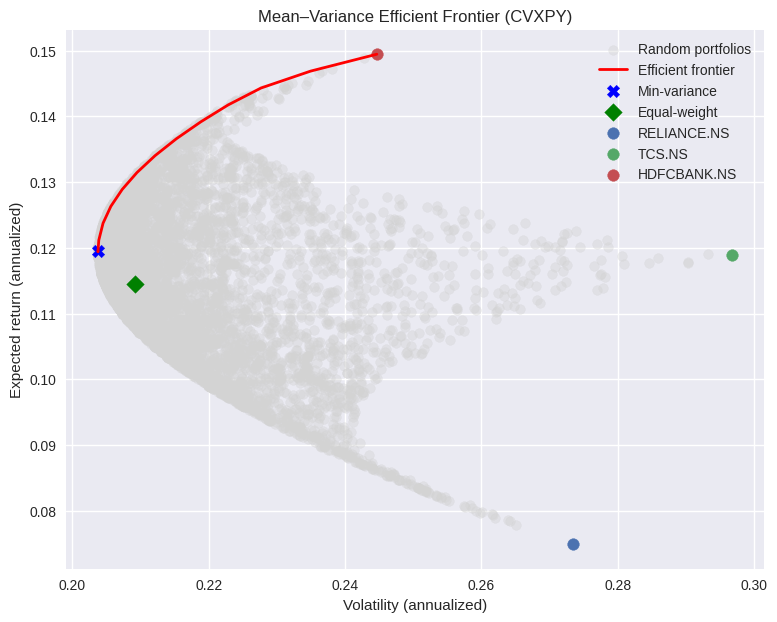

In [ ]:
plt.figure(figsize=(9,7))

# All random portfolios for background (optional)
num_random = 5000
rand_returns = []
rand_vols = []

for _ in range(num_random):
    w_rand = np.random.rand(n)
    w_rand /= w_rand.sum()
    r, v = portfolio_performance(w_rand, mu, cov_annual)
    rand_returns.append(r)
    rand_vols.append(v)

plt.scatter(rand_vols, rand_returns, c="lightgray", alpha=0.4, label="Random portfolios")

# Efficient frontier
plt.plot(frontier_vols, frontier_returns, "r-", lw=2, label="Efficient frontier")

# Min-variance portfolio
plt.scatter(vol_minvar, ret_minvar, c="blue", s=80, marker="X", label="Min-variance")

# Equal-weight portfolio
plt.scatter(vol_equal, ret_equal, c="green", s=80, marker="D", label="Equal-weight")

# Single assets
for t, (r, v) in single_stats.items():
    plt.scatter(v, r, s=70, marker="o", label=t)

plt.xlabel("Volatility (annualized)")
plt.ylabel("Expected return (annualized)")
plt.title("Mean–Variance Efficient Frontier (CVXPY)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
rows = []

rows.append({
    "Portfolio": "Min-Variance",
    "Return": ret_minvar,
    "Volatility": vol_minvar,
    **{f"w_{t}": w for t, w in zip(tickers, w_minvar)}
})

rows.append({
    "Portfolio": "Equal-Weight",
    "Return": ret_equal,
    "Volatility": vol_equal,
    **{f"w_{t}": w for t, w in zip(tickers, w_equal)}
})

for t, (r, v) in single_stats.items():
    row = {
        "Portfolio": f"100% {t}",
        "Return": r,
        "Volatility": v
    }
    for tk in tickers:
        row[f"w_{tk}"] = 1.0 if tk == t else 0.0
    rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df


,Portfolio,Return,Volatility,w_RELIANCE.NS,w_TCS.NS,w_HDFCBANK.NS
0,Min-Variance,0.119445,0.203753,0.329487,0.178320,0.492193
1,Equal-Weight,0.114423,0.209202,0.333333,0.333333,0.333333
2,100% RELIANCE.NS,0.074901,0.273437,1.000000,0.000000,0.000000
3,100% TCS.NS,0.118909,0.296788,0.000000,1.000000,0.000000
4,100% HDFCBANK.NS,0.149458,0.244666,0.000000,0.000000,1.000000
